## Linear Regression

In [48]:
import numpy as np

def softmax(z):
    # z: (batch, K)
    z = z - np.max(z, axis=1, keepdims=True)  # stability
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(probs, y):
    """
    probs: (n, K) softmax probabilities
    y: (n,) integer class labels in {0..K-1}
    """
    n = y.shape[0]
    return -np.mean(np.log(probs[np.arange(n), y] + 1e-12))

def solve_softmax_regression_via_gradient_descent(
    X, y,
    lr=0.001,
    n_steps=10000,
    tol=1e-6,
    batch_size=512,
    reg=0.0,          # L2 regularization strength (0 = none)
    seed=None
):
    """
    X: (n, d)
    y: (n,) integer labels {0..K-1}
    Returns: loss, W, b, loss_history
    """
    if seed is not None:
        np.random.seed(seed)

    n, d = X.shape
    K = int(np.max(y)) + 1  # number of classes

    W = 0.01 * np.random.randn(d, K)
    b = np.zeros(K)

    loss_history = []
    prev_loss = np.inf
    patience  = 0
    for step in range(n_steps):
        # mini-batch
        idx = np.random.choice(n, size=min(batch_size, n), replace=False)
        Xb = X[idx]                 # (m, d)
        yb = y[idx]                 # (m,)
        m = Xb.shape[0]

        # forward
        logits = Xb @ W + b         # (m, K)
        probs = softmax(logits)     # (m, K)

        # loss (batch)

        loss = cross_entropy_loss(probs, yb) + 0.5 * reg * np.sum(W * W)
        loss_history.append(loss)

        # gradient: (probs - one_hot)
        grad_logits = probs
        grad_logits[np.arange(m), yb] -= 1.0
        grad_logits /= m            # average

        gradW = Xb.T @ grad_logits + reg * W   # (d, K)
        gradb = np.sum(grad_logits, axis=0)    # (K,)

        # update
        W -= lr * gradW
        b -= lr * gradb

        # stopping by small improvement

        if abs(prev_loss - loss) < tol:
            patience += 1
            if patience == 5:
                break
        else:
            patience = 0
        prev_loss = loss

    return loss_history[-1], W, b, loss_history

def predict_softmax(X, W, b):
    probs = softmax(X @ W + b)
    return np.argmax(probs, axis=1)


In [33]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target



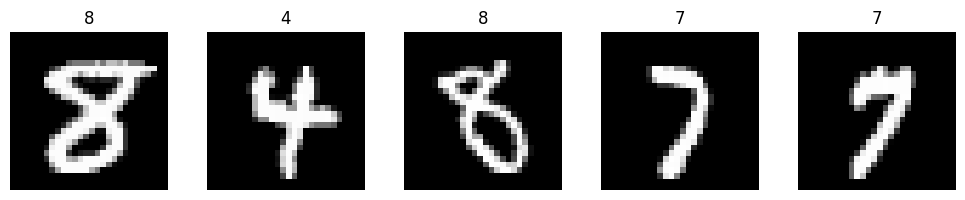

In [34]:
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
indices = rng.choice(len(X), size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for ax, idx in zip(axes, indices):
    ax.imshow(X[idx].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_title(str(y[idx]))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
# Convert target labels to integers
y = y.astype(int)
n_lable = len(set(y))
print(f"Number of labels: {n_lable}")


Number of labels: 10


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
final_loss , W , b ,loss_hist =   solve_softmax_regression_via_gradient_descent(X_train , y_train ,n_steps =1000)

In [39]:
predict  = predict_softmax(X_test , W , b)
acc = accuracy_score(y_test , predict)
print(f"Accuracy: {acc}")

Accuracy: 0.8804285714285714


In [50]:
random_feature_generator  = np.random.RandomState(12).normal(size=(X_train.shape[1], 4096)).astype(np.float32)
Z_train, Z_test = np.maximum(0, X_train.dot(random_feature_generator)), np.maximum(0, X_test.dot(random_feature_generator))

final_loss , W , b ,loss_hist =   solve_softmax_regression_via_gradient_descent(Z_train , y_train ,n_steps = 1000, batch_size = 1024)


predict  = predict_softmax(Z_test , W , b)
acc = accuracy_score(y_test , predict)
print(f"Accuracy: {acc}")

Accuracy: 0.9477857142857142


In [45]:
from sklearn.linear_model import SGDClassifier

W = np.random.RandomState(42).normal(size=(X_train.shape[1], 4096)).astype(np.float32)
Z_train, Z_test = np.maximum(0, X_train.dot(W)), np.maximum(0, X_test.dot(W))

clf = SGDClassifier(
    loss='log_loss',           # logistic regression
    max_iter=1000,             # upper cap
    tol=1e-3,                  # stop when improvement < tol
    early_stopping=True,       # use an internal validation split and stop early
    n_iter_no_change=5,
    validation_fraction=0.1,   # fraction of train set used for early stopping
    random_state=42,
    verbose=0
)

clf.fit(Z_train, y_train)

# Evaluate
y_pred = clf.predict(Z_test)

In [46]:
print("Accuracy (SGDClassifier):", accuracy_score(y_test, y_pred))


Accuracy (SGDClassifier): 0.9680714285714286


# Ridge and Lasso



## **1. Introduction**
Linear regression is a fundamental technique in **quantitative finance** for modeling relationships between financial indicators and future stock returns. In this lecture, we apply:

- **Ordinary Least Squares (OLS)** to estimate feature importance.
- **Ridge Regression** to control overfitting.
- **Lasso Regression** to perform feature selection.

The objective is to predict **next-day returns** using technical indicators.

---

## **2. Define Features and Target**
We define our independent variables (**X**) as technical indicators and past returns. The dependent variable (**y**) is the **next-day return**.




## Ridge regression

## Why Lasso Tends to Produce More Zeros Than Ridge

### Regularization in Lasso and Ridge

- **Lasso Regression (L1 Regularization):**
  - Uses the L1 norm of the coefficients as the penalty:  $$\text{Penalty}_{\text{Lasso}} = \lambda \sum_{j=1}^{p} |\beta_j| $$  

  - The gradient (or subgradient) with respect to a coefficient $\beta_j$ is given by:

    $$ \frac{\partial}{\partial \beta_j} \lambda |\beta_j| = \lambda \cdot \text{sgn}(\beta_j) $$

    where $ \text{sgn}(\beta_j) $ is the sign function:

    - $+1$ if $\beta_j > 0$
    - $-1$ if $\beta_j < 0$
    - Undefined at $\beta_j = 0$ (handled via subgradient methods)
  - **Key Point:** The gradient is **constant in magnitude** (i.e., it does not depend on the size of $\beta_j$). This means that even if $\beta_j$ is very small, the same constant force is applied to push it towards zero.

- **Ridge Regression (L2 Regularization):**
  - Uses the L2 norm squared of the coefficients as the penalty: $$ \text{Penalty}_{\text{Ridge}} = \lambda \sum_{j=1}^{p} \beta_j^2 $$
   

  - The gradient with respect to $\beta_j$ is:
  $$ \frac{\partial}{\partial \beta_j} \lambda \beta_j^2 = 2\lambda \beta_j  $$
    
  - **Key Point:** The gradient is **proportional to the magnitude** of $\beta_j$. Larger coefficients are penalized more strongly, but small coefficients receive a very small push towards zero.

### How This Affects Sparsity

- **Lasso Regression:**
  - Because the gradient (or penalty force) is constant regardless of the magnitude of $\beta_j$ , even small coefficients can be driven exactly to zero.
  - This results in a **sparse solution**, where many coefficients are exactly zero, effectively performing feature selection.

- **Ridge Regression:**
  - Since the gradient depends on $\beta_j$'s magnitude, the shrinkage effect is **more pronounced on larger coefficients**.
  - Small coefficients are shrunk less aggressively, so they rarely become exactly zero.
  - This results in a model where all predictors are retained (although their contributions might be small), leading to **non-sparse** solutions.
